* Juan Mendoza-Martinez
* Perm: 5219522

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip

--2021-06-05 19:24:00--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.33.56, 99.86.33.48, 99.86.33.87, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.33.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.05s   

2021-06-05 19:24:00 (58.0 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [ ]:
!unzip data.zip -d .

Archive:  data.zip
   creating: ./data/
  inflating: ./data/eng-fra.txt      
   creating: ./data/names/
  inflating: ./data/names/Arabic.txt  
  inflating: ./data/names/Chinese.txt  
  inflating: ./data/names/Czech.txt  
  inflating: ./data/names/Dutch.txt  
  inflating: ./data/names/English.txt  
  inflating: ./data/names/French.txt  
  inflating: ./data/names/German.txt  
  inflating: ./data/names/Greek.txt  
  inflating: ./data/names/Irish.txt  
  inflating: ./data/names/Italian.txt  
  inflating: ./data/names/Japanese.txt  
  inflating: ./data/names/Korean.txt  
  inflating: ./data/names/Polish.txt  
  inflating: ./data/names/Portuguese.txt  
  inflating: ./data/names/Russian.txt  
  inflating: ./data/names/Scottish.txt  
  inflating: ./data/names/Spanish.txt  
  inflating: ./data/names/Vietnamese.txt  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

In [ ]:
torch.manual_seed(4)
np.random.seed(4)
random.seed(4)

# Prepare & Split Data

In [ ]:

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


category_lines_train = {}
category_lines_val = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    #Shuffle and Split into Training and Validation data
    random.shuffle(lines)
    lines_train = lines[0:int(len(lines)*0.85)]
    lines_val = lines[int(len(lines)*0.85):len(lines)]
    category_lines_train[category] = lines_train
    category_lines_val[category] = lines_val

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

# Create Network

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# Training

### Helper Functions

In [ ]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair(category_lines):
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [ ]:
def randomTrainingExample(category_lines):
    category, line = randomTrainingPair(category_lines)
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

Validation Function

In [ ]:
def validation(model,category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = model.initHidden()

    model.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = model(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()


    return output, loss.item() / input_line_tensor.size(0)

### Train Function

In [ ]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(model,category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = model.initHidden()

    model.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = model(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in model.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [ ]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
train_losses = []
val_losses = []
total_loss = 0 # Reset every plot_every iters
total_val_loss = 0
val_sample_count = 0
start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(rnn, *randomTrainingExample(category_lines_train))
    total_loss += loss
    
    if iter % print_every == 0:
        for category in all_categories:
          for line in category_lines_val[category]:
            val_sample_count += 1
            category_tensor = categoryTensor(category)
            input_line_tensor = inputTensor(line)
            target_line_tensor = targetTensor(line)
            val_out, val_loss = validation(rnn, category_tensor, input_line_tensor, target_line_tensor)
            total_val_loss += val_loss
        val_losses.append(total_val_loss / val_sample_count)
        total_val_loss = 0
        val_sample_count = 0
        
        print("Loss For Train:")
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))
        print("Loss For Validation:")
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, val_loss))
    
    if iter % plot_every == 0:
        train_losses.append(total_loss / plot_every)
        total_loss = 0
        

Loss For Train:
0m 19s (5000 5%) 2.2727
Loss For Validation:
0m 19s (5000 5%) 2.9094
Loss For Train:
0m 38s (10000 10%) 2.5432
Loss For Validation:
0m 38s (10000 10%) 2.9549
Loss For Train:
0m 57s (15000 15%) 3.0294
Loss For Validation:
0m 57s (15000 15%) 2.9618
Loss For Train:
1m 16s (20000 20%) 2.0233
Loss For Validation:
1m 16s (20000 20%) 2.9498
Loss For Train:
1m 35s (25000 25%) 3.3178
Loss For Validation:
1m 35s (25000 25%) 2.8300
Loss For Train:
1m 54s (30000 30%) 2.3857
Loss For Validation:
1m 54s (30000 30%) 2.8973
Loss For Train:
2m 13s (35000 35%) 2.3018
Loss For Validation:
2m 13s (35000 35%) 2.6575
Loss For Train:
2m 33s (40000 40%) 3.0400
Loss For Validation:
2m 33s (40000 40%) 2.5637
Loss For Train:
2m 52s (45000 45%) 3.1120
Loss For Validation:
2m 52s (45000 45%) 2.4874
Loss For Train:
3m 11s (50000 50%) 3.2907
Loss For Validation:
3m 11s (50000 50%) 2.3753
Loss For Train:
3m 31s (55000 55%) 2.5974
Loss For Validation:
3m 31s (55000 55%) 2.4419
Loss For Train:
3m 50s (6

# (A)

### Graph the training and validation loss

In [ ]:
num_train_samples = len(train_losses)
num_test_samples = len(val_losses)
x_train_list = np.linspace(1, num_train_samples*500, num_train_samples)
x_val_list = np.linspace(1, num_test_samples*5000, num_test_samples)

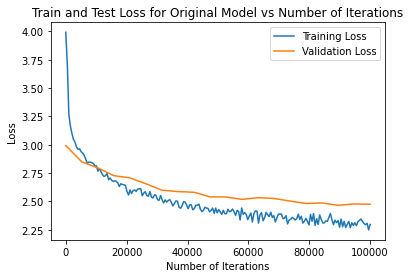

In [ ]:

plt.plot(x_train_list, train_losses, label="Training Loss")
plt.plot(x_val_list, val_losses, label="Validation Loss")
plt.title("Train and Test Loss for Original Model vs Number of Iterations")
plt.ylabel("Loss")
plt.xlabel("Number of Iterations")
plt.legend()

# (B)

In [ ]:
class RNN_no_drop(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_no_drop, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
rnn_no_drop = RNN_no_drop(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
no_drop_train_losses = []
no_drop_val_losses = []
total_loss = 0 # Reset every plot_every iters
total_val_loss = 0
val_sample_count = 0
start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(rnn_no_drop, *randomTrainingExample(category_lines_train))
    total_loss += loss

    if iter % print_every == 0:
        for category in all_categories:
          for line in category_lines_val[category]:
            val_sample_count += 1
            category_tensor = categoryTensor(category)
            input_line_tensor = inputTensor(line)
            target_line_tensor = targetTensor(line)
            val_out, val_loss = validation(rnn_no_drop, category_tensor, input_line_tensor, target_line_tensor)
            total_val_loss += val_loss
        no_drop_val_losses.append(total_val_loss / val_sample_count)
        total_val_loss = 0
        val_sample_count = 0
        
        print("Loss For Train:")
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))
        print("Loss For Validation:")
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, val_loss))
    
    if iter % plot_every == 0:
        no_drop_train_losses.append(total_loss / plot_every)
        total_loss = 0
        

Loss For Train:
0m 16s (5000 5%) 3.9725
Loss For Validation:
0m 16s (5000 5%) 2.8759
Loss For Train:
0m 33s (10000 10%) 2.6586
Loss For Validation:
0m 33s (10000 10%) 2.8842
Loss For Train:
0m 49s (15000 15%) 3.7110
Loss For Validation:
0m 49s (15000 15%) 2.8619
Loss For Train:
1m 4s (20000 20%) 2.1720
Loss For Validation:
1m 4s (20000 20%) 2.7051
Loss For Train:
1m 19s (25000 25%) 2.2114
Loss For Validation:
1m 19s (25000 25%) 2.7584
Loss For Train:
1m 35s (30000 30%) 2.2891
Loss For Validation:
1m 35s (30000 30%) 2.6761
Loss For Train:
1m 50s (35000 35%) 1.9969
Loss For Validation:
1m 50s (35000 35%) 2.6852
Loss For Train:
2m 5s (40000 40%) 1.9893
Loss For Validation:
2m 5s (40000 40%) 2.4916
Loss For Train:
2m 21s (45000 45%) 1.9156
Loss For Validation:
2m 21s (45000 45%) 2.4721
Loss For Train:
2m 36s (50000 50%) 1.8143
Loss For Validation:
2m 36s (50000 50%) 2.3007
Loss For Train:
2m 52s (55000 55%) 2.4076
Loss For Validation:
2m 52s (55000 55%) 2.3179
Loss For Train:
3m 9s (60000 

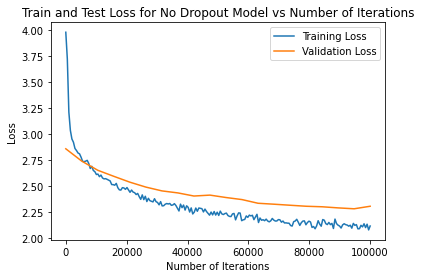

In [ ]:
num_train_samples = len(no_drop_train_losses)
num_test_samples = len(no_drop_val_losses)
x_train_list = np.linspace(1, num_train_samples*500, num_train_samples)
x_val_list = np.linspace(1, num_test_samples*5000, num_test_samples)

plt.plot(x_train_list, no_drop_train_losses, label="Training Loss")
plt.plot(x_val_list, no_drop_val_losses, label="Validation Loss")
plt.title("Train and Test Loss for No Dropout Model vs Number of Iterations")
plt.ylabel("Loss")
plt.xlabel("Number of Iterations")
plt.legend()

# (C)

In [ ]:
class RNN_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_reg, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

### Redefined the train and validate functions in order to account for the L2 regularization through the optimizer

In [ ]:
criterion = nn.NLLLoss()
rnn_reg = RNN_reg(n_letters, 128, n_letters)


learning_rate = 0.0005

def train(model,category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = model.initHidden()

    model.zero_grad()

    loss = 0
    
    #######################################
    #L2 Normalization:
    #Inspired by: https://stackoverflow.com/questions/50149376/how-to-add-a-l2-regularization-term-in-my-loss-function
    reg = 0
    reg_lambda = 0.01
    for param in model.parameters():
      reg += 0.5 * (param ** 2).sum() #l2
    #######################################
    for i in range(input_line_tensor.size(0)):
        output, hidden = model(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i]) 
        loss += l
    
    loss += reg_lambda * reg
    loss.backward()
    

    for p in model.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)



In [ ]:


n_iters = 100000
print_every = 5000
plot_every = 500
reg_train_losses = []
reg_val_losses = []
total_loss = 0 # Reset every plot_every iters
total_val_loss = 0
val_sample_count = 0
start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(rnn_reg, *randomTrainingExample(category_lines_train))
    total_loss += loss

    if iter % print_every == 0:
        for category in all_categories:
          for line in category_lines_val[category]:
            val_sample_count += 1
            category_tensor = categoryTensor(category)
            input_line_tensor = inputTensor(line)
            target_line_tensor = targetTensor(line)
            val_out, val_loss = validation(rnn_reg, category_tensor, input_line_tensor, target_line_tensor)
            total_val_loss += val_loss
        reg_val_losses.append(total_val_loss / val_sample_count)
        total_val_loss = 0
        val_sample_count = 0
        
        print("Loss For Train:")
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))
        print("Loss For Validation:")
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, val_loss))
    
    if iter % plot_every == 0:
        reg_train_losses.append(total_loss / plot_every)
        total_loss = 0
        

Loss For Train:
0m 18s (5000 5%) 2.8553
Loss For Validation:
0m 18s (5000 5%) 2.9585
Loss For Train:
0m 38s (10000 10%) 2.3464
Loss For Validation:
0m 38s (10000 10%) 2.9085
Loss For Train:
0m 57s (15000 15%) 2.7247
Loss For Validation:
0m 57s (15000 15%) 2.9408
Loss For Train:
1m 16s (20000 20%) 2.1459
Loss For Validation:
1m 16s (20000 20%) 2.9226
Loss For Train:
1m 35s (25000 25%) 2.0397
Loss For Validation:
1m 35s (25000 25%) 2.8580
Loss For Train:
1m 54s (30000 30%) 2.5448
Loss For Validation:
1m 54s (30000 30%) 2.7135
Loss For Train:
2m 13s (35000 35%) 2.4081
Loss For Validation:
2m 13s (35000 35%) 2.7260
Loss For Train:
2m 32s (40000 40%) 2.5889
Loss For Validation:
2m 32s (40000 40%) 2.7207
Loss For Train:
2m 51s (45000 45%) 2.0619
Loss For Validation:
2m 51s (45000 45%) 2.6211
Loss For Train:
3m 10s (50000 50%) 1.6266
Loss For Validation:
3m 10s (50000 50%) 2.5952
Loss For Train:
3m 29s (55000 55%) 3.1748
Loss For Validation:
3m 29s (55000 55%) 2.5284
Loss For Train:
3m 48s (6

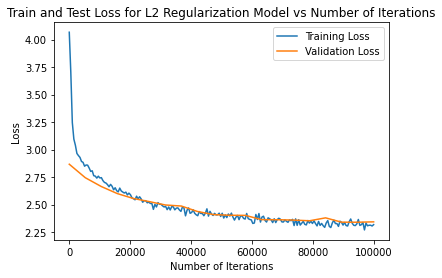

In [ ]:
num_train_samples = len(reg_train_losses)
num_test_samples = len(reg_val_losses)
x_train_list = np.linspace(1, num_train_samples*500, num_train_samples)
x_val_list = np.linspace(1, num_test_samples*5000, num_test_samples)

plt.plot(x_train_list, reg_train_losses, label="Training Loss")
plt.plot(x_val_list, reg_val_losses, label="Validation Loss")
plt.title("Train and Test Loss for L2 Regularization Model vs Number of Iterations")
plt.ylabel("Loss")
plt.xlabel("Number of Iterations")
plt.legend()

# (D)

In [ ]:
max_length = 20

# Sample from a category and starting letter
def sample(model,category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = model.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = model(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

In [ ]:

print("Original model: ")
print("English: " + sample(rnn, 'English', 'J'))
print("Portuguese: " + sample(rnn, 'Portuguese', 'J'))
print("Russian: " + sample(rnn, 'Russian', 'J'))
print("Greek: " + sample(rnn, 'Greek', 'J'))
print("Chinese: " + sample(rnn, 'Chinese', 'J'))
print("Dutch: " + sample(rnn, 'Dutch', 'J'))


print("\n Model without dropout: ")
print("English: " + sample(rnn_no_drop, 'English', 'J'))
print("Portuguese: " + sample(rnn_no_drop, 'Portuguese', 'J'))
print("Russian: " + sample(rnn_no_drop, 'Russian', 'J'))
print("Greek: " + sample(rnn_no_drop, 'Greek', 'J'))
print("Chinese: " + sample(rnn_no_drop, 'Chinese', 'J'))
print("Dutch: " + sample(rnn_no_drop, 'Dutch', 'J'))


print("\n Model with Regularization: ")
print("English: " + sample(rnn_reg, 'English', 'J'))
print("Portuguese: " + sample(rnn_reg, 'Portuguese', 'J'))
print("Russian: " + sample(rnn_reg, 'Russian', 'J'))
print("Greek: " + sample(rnn_reg, 'Greek', 'J'))
print("Chinese: " + sample(rnn_reg, 'Chinese', 'J'))
print("Dutch: " + sample(rnn_reg, 'Dutch', 'J'))

Original model: 
English: Jander
Portuguese: Jarero
Russian: Jander
Greek: Jangasou
Chinese: Jang
Dutch: Jeren

 Model without dropout: 
English: Janger
Portuguese: Jares
Russian: Jantonov
Greek: Jantos
Chinese: Jan
Dutch: Janeren

 Model with Regularization: 
English: Janter
Portuguese: Jarta
Russian: Jantov
Greek: Jantos
Chinese: Jan
Dutch: Janer
